In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
store_sales = pd.read_csv("drive/MyDrive/data/train.csv")
store_sales.head(15)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
store_sales = store_sales.drop(['store', 'item'], axis=1)

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


Konvertuojame date is object i DataType

In [ ]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


Konvertuojame date i month periodus, ir sumuojame sales kiekviename month

In [ ]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

Konvertuojame rezultatus i timestamp datatype

In [ ]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [ ]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


Vizualizacijos

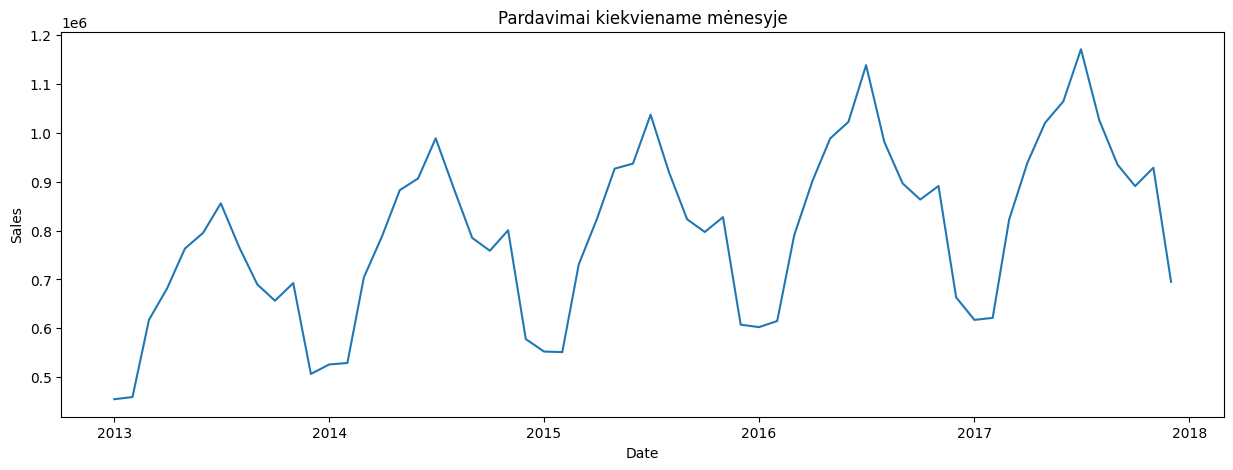

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Pardavimai kiekviename mėnesyje")
plt.show()

In [ ]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


In [ ]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

In [ ]:
for i in range(1, 13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Padaliname duomenys i mokymo/testavimo duomenys

In [ ]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print(train_data.shape)
print(test_data.shape)

(35, 13)
(12, 13)


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_train.shape)

X_train Shape:  (35, 12)
y_train Shape:  (35,)
X_test Shape:  (12, 12)
y_test Shape:  (35,)


In [ ]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [ ]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [ ]:
lr_pre = lr_pre.reshape(-1, 1)
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)


In [ ]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [ ]:
lr_mse = np.sqrt(mean_squared_error(predict_df["Linear Prediction"], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df["Linear Prediction"], monthly_sales['sales'][-12:])
lr_r2 = r2_score(monthly_sales['sales'][-12:], predict_df["Linear Prediction"])

print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)
#print(predict_df)

Linear Regression MSE:  16221.272385416869
Linear Regression MAE:  12433.184266490736
Linear Regression R2:  0.990715322853555


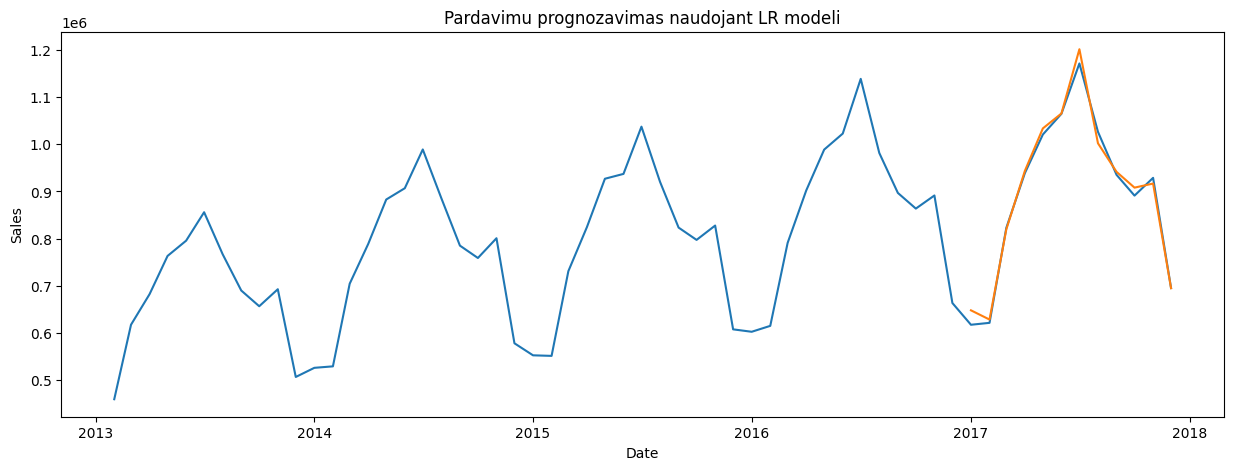

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Pardavimu prognozavimas naudojant LR modeli")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [ ]:
X_train, y_train = train_data[:, 1:], train_data[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_data[:, 1:], test_data[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape)


(35, 1, 12)


In [ ]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, 1, 12), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1, shuffle=False)


Epoch 1/50
35/35 [==============================] - 2s 2ms/step - loss: 0.1484
Epoch 2/50
35/35 [==============================] - 0s 2ms/step - loss: 0.1429
Epoch 3/50
35/35 [==============================] - 0s 2ms/step - loss: 0.1214
Epoch 4/50
35/35 [==============================] - 0s 2ms/step - loss: 0.1061
Epoch 5/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0934
Epoch 6/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0823
Epoch 7/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0722
Epoch 8/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0630
Epoch 9/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0548
Epoch 10/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0475
Epoch 11/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0412
Epoch 12/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0357
Epoch 13/50
35/35 [==============================

In [ ]:
y_pred = model.predict(X_test, batch_size=1)
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])


12/12 [==============================] - 1s 3ms/step


In [ ]:
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

[[ 0.05363538 -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352
   0.68397168  0.27578914  0.53846345  0.65919343  0.98155922  0.16933959
   0.0816042 ]]
[[ 0.15494558 -0.12204966 -1.02635392  0.24535439 -0.05787474 -0.31370458
  -0.67437352  0.68397168  0.27578914  0.53846345  0.65919343  0.98155922
   0.16933959]]
[[ 1.04404461  0.12731349 -0.12204966 -1.02635392  0.24535439 -0.05787474
  -0.31370458 -0.67437352  0.68397168  0.27578914  0.53846345  0.65919343
   0.98155922]]
[[ 0.66935837  1.10768225  0.12731349 -0.12204966 -1.02635392  0.24535439
  -0.05787474 -0.31370458 -0.67437352  0.68397168  0.27578914  0.53846345
   0.65919343]]
[[ 0.53926671  0.68467253  1.10768225  0.12731349 -0.12204966 -1.02635392
   0.24535439 -0.05787474 -0.31370458 -0.67437352  0.68397168  0.27578914
   0.53846345]]
[[ 0.32282099  0.51382935  0.68467253  1.10768225  0.12731349 -0.12204966
  -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352  0.68397168
   0.27578914]]
[[ 0.6548478   0

In [ ]:
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [ ]:
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [ ]:
result_list = []
sales_dates = list(monthly_sales[-13:].date)
act_sales = list(monthly_sales[-13:].sales)

for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [ ]:
df_result

,pred_value,date
0,650142,2017-01-01
1,624687,2017-02-01
2,809980,2017-03-01
3,934904,2017-04-01
4,1024582,2017-05-01
5,1062286,2017-06-01
6,1173903,2017-07-01
7,1038967,2017-08-01
8,923288,2017-09-01
9,917601,2017-10-01


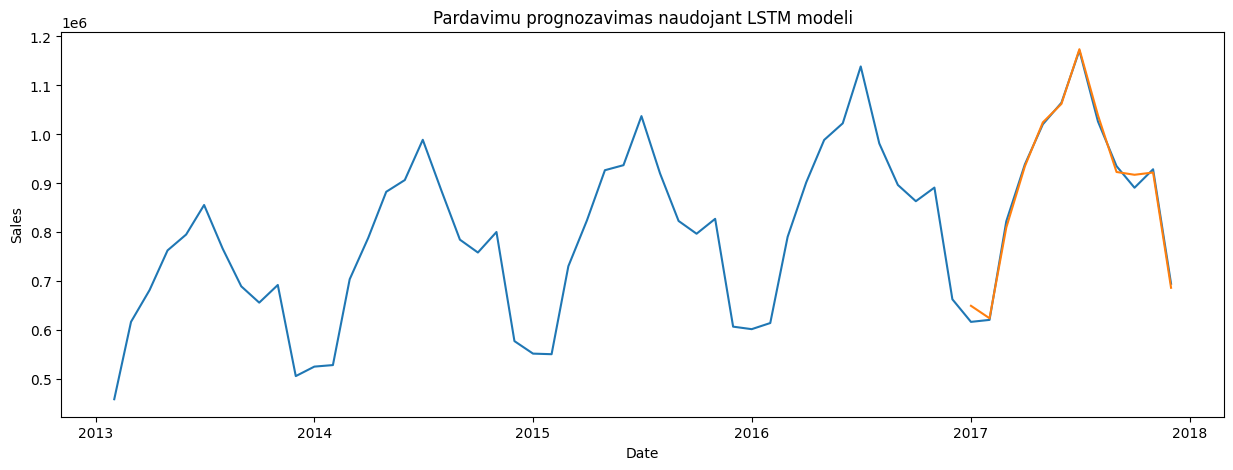

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(df_result['date'], df_result['pred_value'])
plt.title("Pardavimu prognozavimas naudojant LSTM modeli")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [ ]:
lstm_mse = np.sqrt(mean_squared_error(df_result['pred_value'], monthly_sales['sales'][-12:]))
lstm_mae = mean_absolute_error(df_result['pred_value'], monthly_sales['sales'][-12:])
lstm_r2 = r2_score(monthly_sales['sales'][-12:], df_result['pred_value'])

print("LSTM MSE: ", lstm_mse)
print("LSTM MAE: ", lstm_mae)
print("LSTM R2: ", lstm_r2)

LSTM MSE:  14157.37839137835
LSTM MAE:  10616.583333333334
LSTM R2:  0.9929276677938841
